<a href="https://colab.research.google.com/github/viv1more/Customer-Segmentation/blob/main/customersegproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task :
1. Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
2. To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.

Steps :
1. Data Preparation
2. Exploring the content of variables (in short, Exploratory Data Analysis, not inlcuding the product category)
3. Intuitions about the categories of the product, the customer buys
4. Categories of the Customer that buys the product
5. Classifying the Customers based on some parameters
6. Testing the Predictions

# Understanding the content of Data
### "This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.



#  1. Data Preparation

In [ ]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")                                    # Ignoring the warnings
plt.rcParams["patch.force_edgecolor"] = True                         # Setting the default style of Matplotlib
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [ ]:
# Loading the Data

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
df_initial = pd.read_csv('/content/drive/MyDrive/Dataset/file1.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#------------------------------------------------
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#------------------------------------------------
# getting the information about the column type and the null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (no.)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#---------------------------------------------------
# show first 5 lines
display(df_initial[:5])

Dataframe dimensions: (9999, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (no.),0,0,28,0,0,0,4361,0
null values (%),0.0,0.0,0.280028,0.0,0.0,0.0,43.614361,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,537224,22497,SET OF 2 TINS VINTAGE BATHROOM,2,2010-12-05 16:24:00,4.25,13174,United Kingdom
1,537224,22500,SET OF 2 TINS JARDIN DE PROVENCE,2,2010-12-05 16:24:00,4.95,13174,United Kingdom
2,537224,21187,WHITE BELL HONEYCOMB PAPER GARLAND,2,2010-12-05 16:24:00,1.65,13174,United Kingdom
3,537224,84809A,WHITE CHRYSANTHEMUMS ART FLOWER,6,2010-12-05 16:24:00,2.10,13174,United Kingdom
4,537224,79321,CHILLI LIGHTS,2,2010-12-05 16:24:00,4.95,13174,United Kingdom


# Observations:
* Since null values, play an important role in the analysis, we can observe that from the 'CustomerID' about 25 % data is missing. So, an simple and easy way to handle those missing values is to remove thpose missing values. And, I think that removing those customers, we will be able to remove the missing values that are present in the 'Description' column.




# 2. Exploring the content of variables

In [ ]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#--------------------------------------------------
# gives some information on columns types and numer of null values in each column
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (no)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (5638, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (no),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* So, we have removed the missing values, and as intuited the missing values present in the 'Description' cloumn has also been removed. So, now the next step would be as mentioned below:

* Some orders have been cancelled and hence, in order to nullify those experience, the thing that the retailer have done is to create a new order in which the quantites have been the negative of the previously ordered quantities.

* So, now let us go for the analysis of the duplicate enteries.

In [ ]:
print('Duplicate Entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate Entries: 112


* Ok, the dupicated enteries are 5225. We will go for the analysis and the dealing procedure for handling the duplicate enteries.

* But before that, let us see that which are the primary countries from which the orders are coming.

In [ ]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Total number of countries: {}'.format(len(countries)))

Total number of countries: 11


In [ ]:
import plotly.graph_objs as go
from plotly.offline import plot

data = dict(
    type='choropleth',
    locations=countries.index,
    locationmode='country names',
    z=countries,
    text=countries.index,
    colorbar={'title': 'Order nb.'},
    colorscale=[[0, 'rgb(224,255,255)'],
                [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
                [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
                [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
                [1, 'rgb(227,26,28)']],
    reversescale=False
)

layout = dict(
    title='Number of orders per country',
    geo=dict(showframe=True, projection={'type': 'mercator'})
)

choromap = go.Figure(data=[data], layout=layout)

plot(choromap, validate=False, filename='choropleth_map.html')


'choropleth_map.html'

* So, the primary country from which the orders are coming is mainly United Kingdoms with 19.5K orders approximately, followed by France and Germany

# 3. Intuitons about the categories of the product, the customer buys.

* Now, let us see that the orders that are being processed have how many different values coresponding to different categories.

In [ ]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,1473,357,285


* I can see in the dataframe that some orders have the InvoiceNo to be starting with the letter 'C' which indicates that the order have been cancelled. So, let us see those orders

In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
no_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
no_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12347,537626,31
1,12386,537676,8
2,12433,537868,74
3,12441,537693,11
4,12474,C537333,1
5,12481,537892,10
6,12494,537967,3
7,12567,537468,20
8,12586,C537232,1
9,12621,537894,14


In [ ]:
no_products_per_basket['order_canceled'] = no_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(no_products_per_basket[:5])
#---------------------------------------
n1 = no_products_per_basket['order_canceled'].sum()
n2 = no_products_per_basket.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12347,537626,31,0
1,12386,537676,8,0
2,12433,537868,74,0
3,12441,537693,11,0
4,12474,C537333,1,1


Number of orders cancelled: 50/357 (14.01%) 


In [ ]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4941,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland
4949,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,2010-12-07 14:57:00,3.75,12347,Iceland
4950,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,2010-12-07 14:57:00,3.75,12347,Iceland
4951,537626,22727,ALARM CLOCK BAKELIKE RED,4,2010-12-07 14:57:00,3.75,12347,Iceland
4952,537626,22728,ALARM CLOCK BAKELIKE PINK,4,2010-12-07 14:57:00,3.75,12347,Iceland


At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [ ]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity']   > 0)].copy()
    #-----------------------------
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    #-----------------------
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    #--------------------------
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In the above function, I checked the two cases:

1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 13
doubtfull_entry: 115


So, now as decided we will be dropping the rows belonging to 'entry_to_remove' as well as 'doubtfull_entry'

But wait, what if some orders which corresponds to discount did not come into the function adn did not got deleted. So, let us check for the same.!!!

In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

no of entries to delete: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


So, now we have performed the Filtering of the Data, let us go for the stock-code and analysis what are the various categories encrypted in the 'StockCode' column!!!

In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['M', 'POST', 'C2', 'D'], dtype=object)

Now, as we know what are the codes for the stockcodes, let us see what do they really stand for, I mean to say that what are th fullforms or the terminology for the stockcode that is given.

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

M               -> Manual                        
POST            -> POSTAGE                       
C2              -> CARRIAGE                      
D               -> Discount                      


As we have seen, the description of the stockcode, now it is time for creating a column named TotalPrice, which will be calculating:

Unit Price * Quantities

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
4947,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.00
4940,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland,0,17.00
4969,537626,20782,CAMOUFLAGE EAR MUFF HEADPHONES,6,2010-12-07 14:57:00,5.49,12347,Iceland,0,32.94
4968,537626,20780,BLACK EAR MUFF HEADPHONES,12,2010-12-07 14:57:00,4.65,12347,Iceland,0,55.80
4967,537626,84558A,3D DOG PICTURE PLAYING CARDS,24,2010-12-07 14:57:00,2.95,12347,Iceland,0,70.80


Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order price. in short, creating a new column which includes the total basket price of an individual customer which simplifies the analysis.

In [ ]:
#-------------------------------
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#-----------------
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#-------------------
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12347,537626,711.79,2010-12-07 14:57:00
1,12386,537676,258.90,2010-12-08 09:53:00
2,12433,537868,1867.98,2010-12-08 16:49:00
3,12441,537693,173.55,2010-12-08 10:45:00
4,12481,537892,159.38,2010-12-09 10:13:00
5,12494,537967,57.60,2010-12-09 11:31:00


Since, Pie-Chart is an important visualization for describing the total breakdown of the single entity, ehich in our cases are the total categories from which the revenues come (i.e the various segment budgets ), we will visualizae it now.

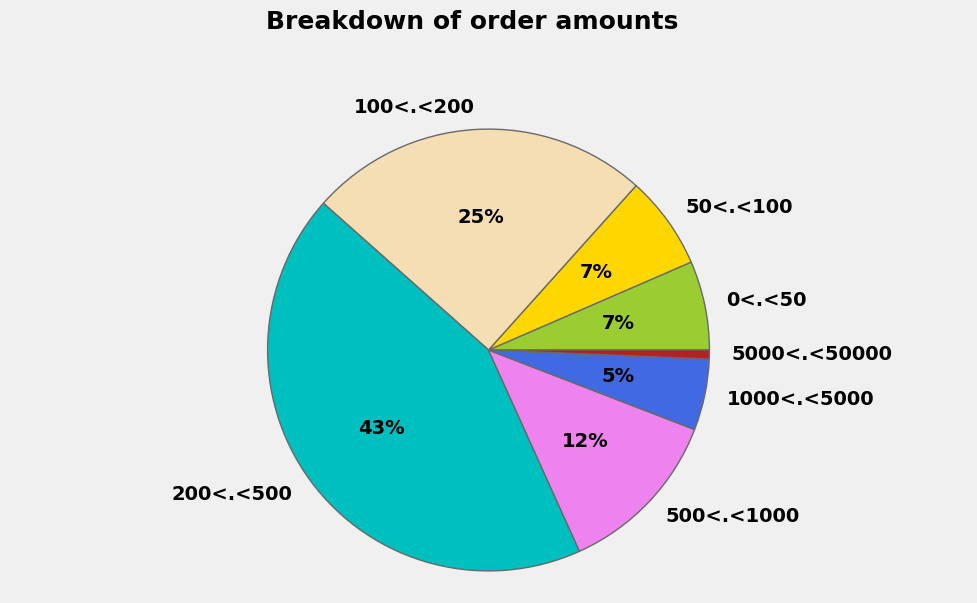

In [ ]:
# Purchase statement
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#-----------------------------------------
# Representation of the number of purchases / amount
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order amounts", ha='center', fontsize = 18);

So, the most revenues are generated from the segmented which are ∼ 65% of purchases give prices in excess of £ 200.

Now for the word analysis, we would extract from the Description variable the information that will prove useful. To do this, we will use the following function:

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

* extract the names (proper, common) appearing in the products description
* for each name, I extract the root of the word and aggregate the set of names associated with this particular root
* count the number of times each root appears in the dataframe
* when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)
* The first step of the analysis is to retrieve the list of products:


In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

# 4. Categories of the Customer that buys the product

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Now, let us see the number of keywords in variable 'Description'

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No. of keywords in variable 'Description': 853


The execution of this function returns three variables:

* keywords: the list of extracted keywords
* keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
* count_keywords: dictionary listing the number of times every word is used

At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:


In [ ]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Now, we will create a graph of the most frequently occuring words

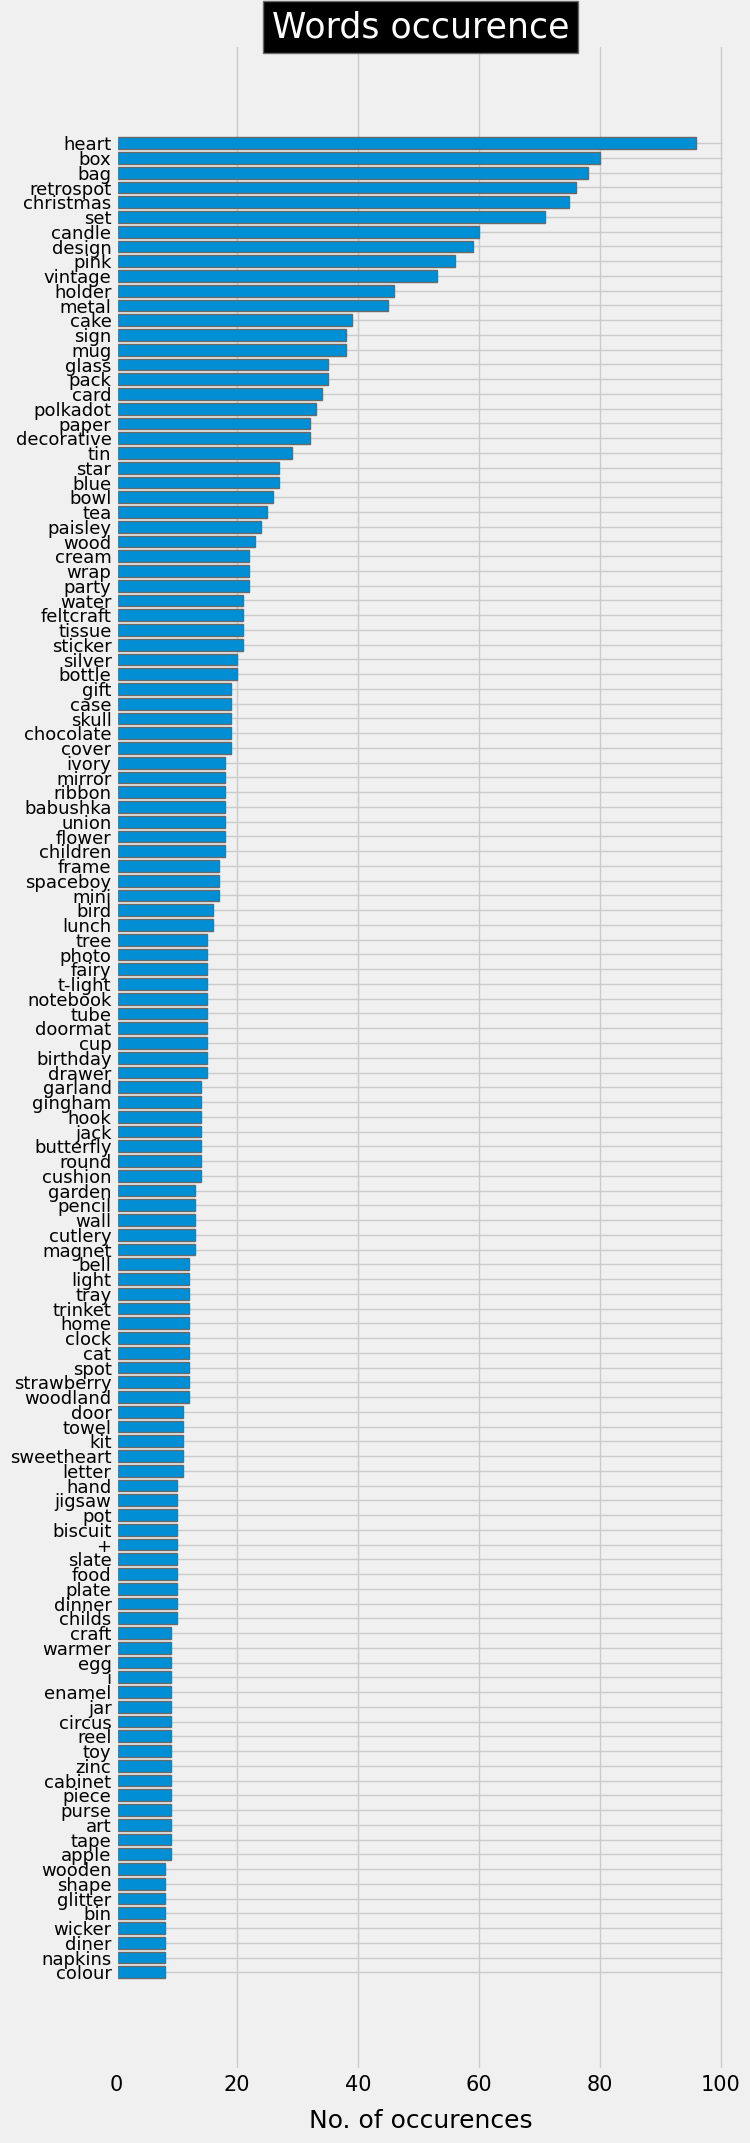

In [ ]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#--------------------------
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#---------------------------------------------------
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [ ]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#-------------------------------------------
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 74


In [ ]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [ ]:
print("{:<8} {:<20} \n".format('range', 'no. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    no. of products      
--------------------
0<.<1       325                 
1<.<2       415                 
2<.<3       288                 
3<.<5       213                 
5<.<10      171                 
.>10        49                  


In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that the kmeans method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the kmodes package which is not available on the current plateform. Hence, I use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [ ]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.15855141849034685
For n_clusters = 4 The average silhouette_score is : 0.19486766551070384
For n_clusters = 5 The average silhouette_score is : 0.21538105901150112
For n_clusters = 6 The average silhouette_score is : 0.21579755953358115
For n_clusters = 7 The average silhouette_score is : 0.19936916562212054
For n_clusters = 8 The average silhouette_score is : 0.2075210646136054
For n_clusters = 9 The average silhouette_score is : 0.19568975614842055


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.05  will be obtained for all clusters with n_clusters  >  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [ ]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.21538105901150112


I check the number of elements in every class:

In [ ]:
pd.Series(clusters).value_counts()

3    415
0    325
1    288
4    220
2    213
dtype: int64

a / Silhouette intra-cluster score

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters.

In [ ]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #------------------------------
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #-------------------------------------------------
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #--------------------------------------------------------------
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #------------------------------
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

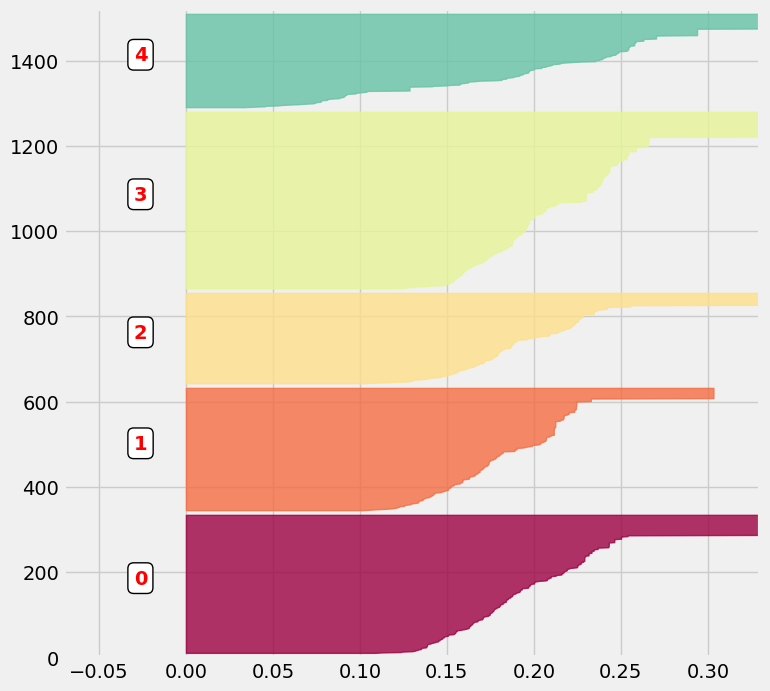

In [ ]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#--------------------------
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

b/ Word Cloud

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [ ]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

Making the wordcloud

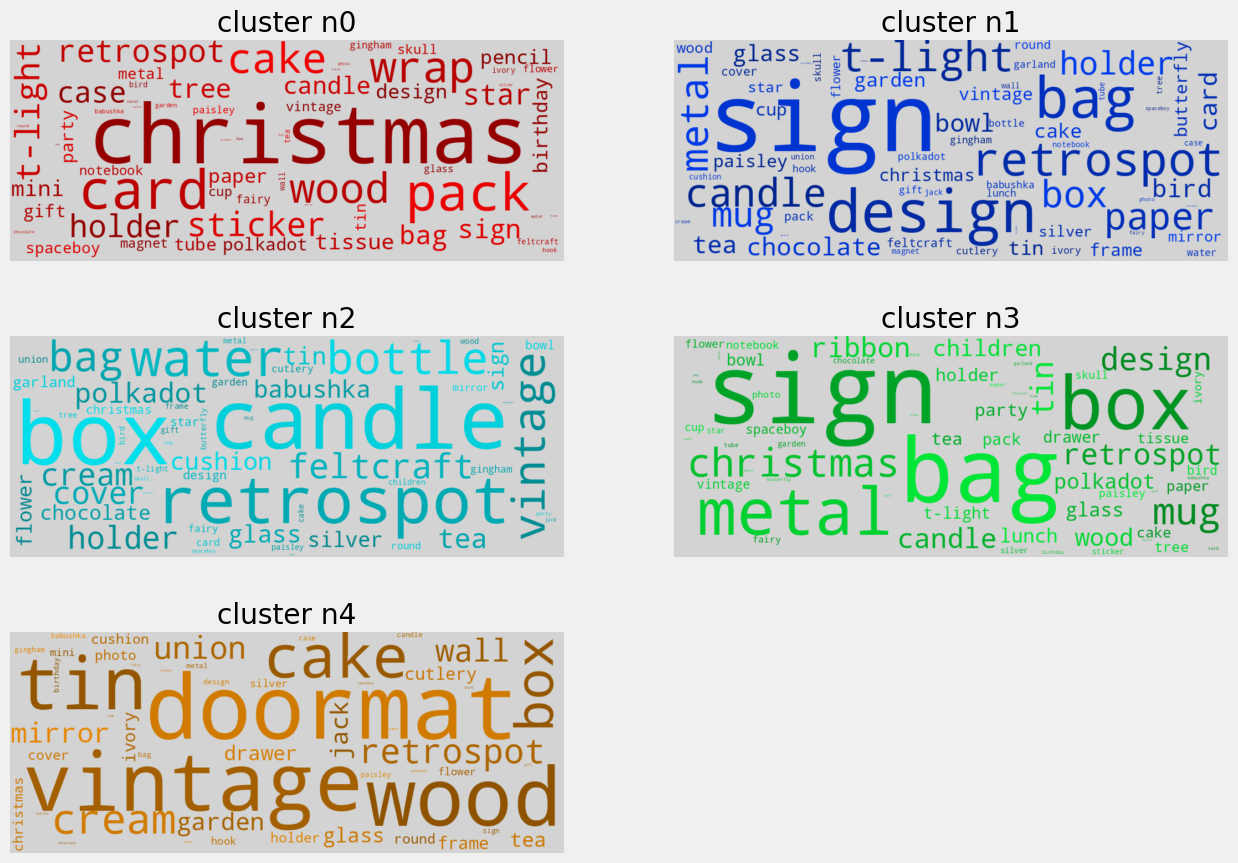

In [ ]:
#--------------------------------
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#-------------------------------------------
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #----------------------------------------------
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey',
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))
#----------------------------------
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

c / Principal Component Analysis

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [ ]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

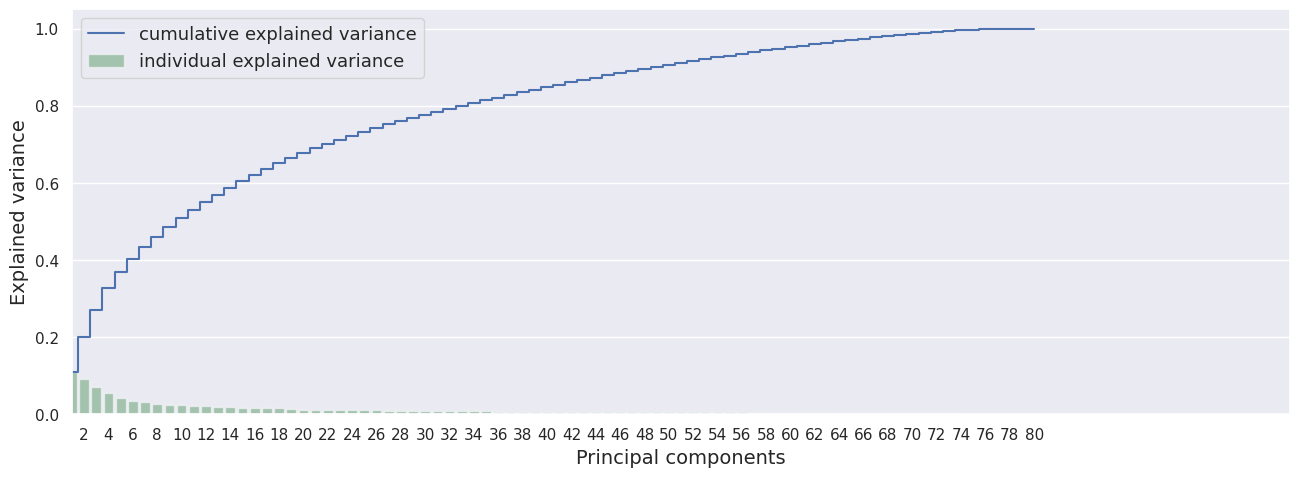

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [ ]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

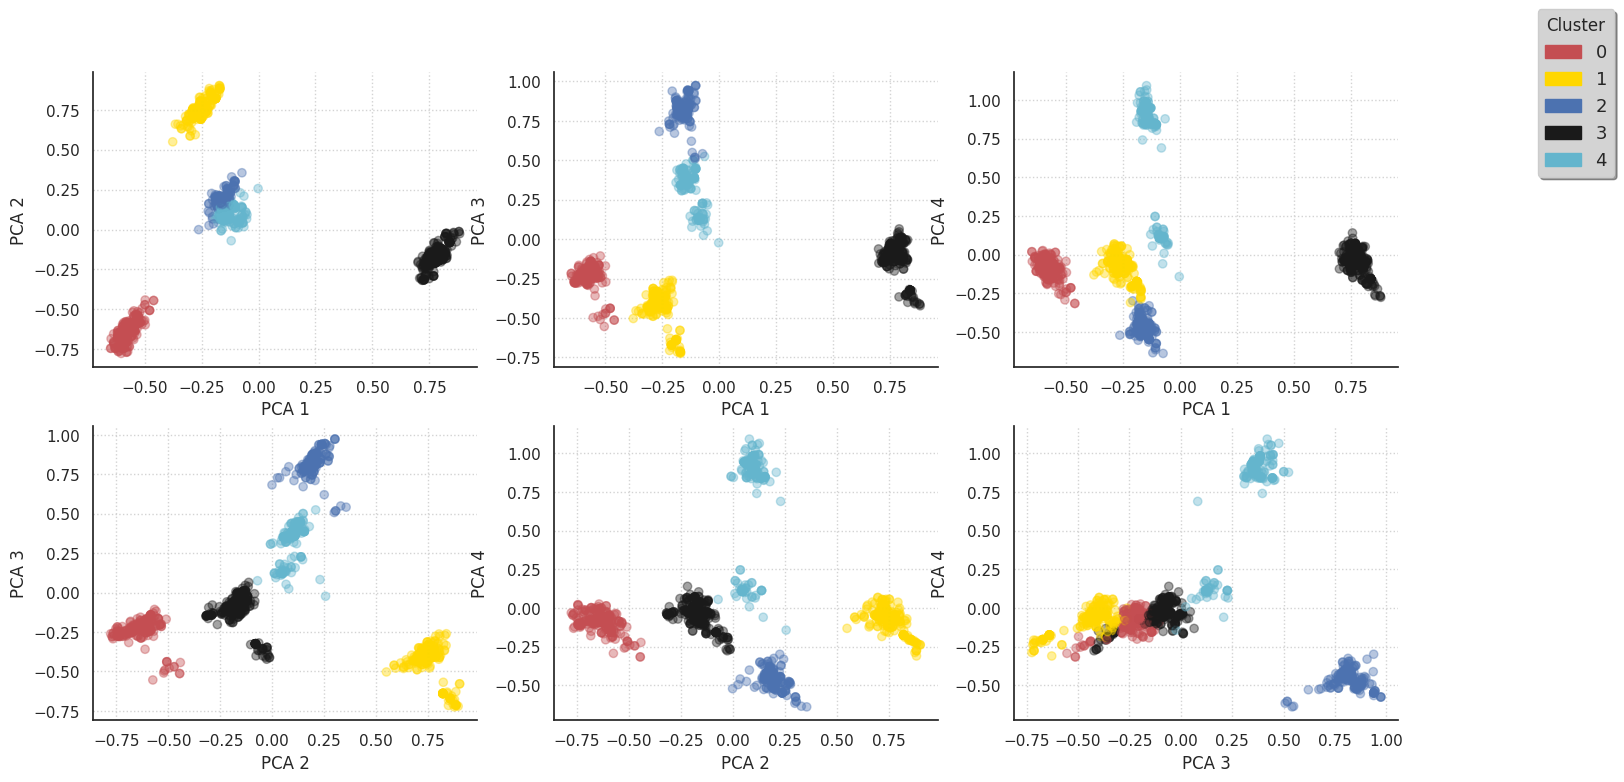

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 9: break
    if increment == 9: break

#------------------------------
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluster of each product :

In [ ]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val
#-------------------------------
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In a second step, I decide to create the categ_N variables (with  N∈[0:4] ) that contains the amount spent in each product category:

In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#-------------------------------------
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,537224,SET OF 2 TINS VINTAGE BATHROOM,2,0.0,0.0,8.5,0.0,0.0
1,537224,SET OF 2 TINS JARDIN DE PROVENCE,2,0.0,0.0,9.9,0.0,0.0
2,537224,WHITE BELL HONEYCOMB PAPER GARLAND,3,0.0,0.0,0.0,3.3,0.0
3,537224,WHITE CHRYSANTHEMUMS ART FLOWER,1,0.0,12.6,0.0,0.0,0.0
4,537224,CHILLI LIGHTS,2,0.0,0.0,9.9,0.0,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [ ]:
#---------------------------
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#---------------------------------
# percentage of order price / product category
for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp [col]
#-----------------------
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347,537626,711.79,23.40,146.1,255.85,162.00,124.44,2010-12-07 14:57:00
1,12386,537676,258.90,43.20,17.7,0.00,99.60,98.40,2010-12-08 09:53:00
2,12433,537868,1867.98,431.52,282.3,70.60,879.26,204.30,2010-12-08 16:49:00
3,12441,537693,173.55,31.50,70.8,38.25,15.00,18.00,2010-12-08 10:45:00
4,12481,537892,159.38,10.08,35.4,0.00,65.40,48.50,2010-12-09 10:13:00


The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-05 16:24:00 -> 2010-12-09 11:44:00


In [ ]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.to_datetime(datetime.date(2011,10,1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.to_datetime(datetime.date(2011,10,1))]
basket_price = set_entrainement.copy(deep = True)

4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:
# number of visits and stats on the amount of the cart / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,1,711.79,711.79,711.79,711.79,3.287486,20.525717,35.944590,22.759522,17.482684
1,12386,1,258.90,258.90,258.90,258.90,16.685979,6.836616,0.000000,38.470452,38.006952
2,12433,1,1867.98,1867.98,1867.98,1867.98,23.100890,15.112582,3.779484,47.070097,10.936948
3,12441,1,173.55,173.55,173.55,173.55,18.150389,40.795160,22.039758,8.643042,10.371651
4,12481,1,159.38,159.38,159.38,159.38,6.324507,22.211068,0.000000,41.034007,30.430418


Finally, I define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,1,711.79,711.79,711.79,711.79,3.287486,20.525717,35.944590,22.759522,17.482684,2,2
1,12386,1,258.90,258.90,258.90,258.90,16.685979,6.836616,0.000000,38.470452,38.006952,1,1
2,12433,1,1867.98,1867.98,1867.98,1867.98,23.100890,15.112582,3.779484,47.070097,10.936948,1,1
3,12441,1,173.55,173.55,173.55,173.55,18.150389,40.795160,22.039758,8.643042,10.371651,1,1
4,12481,1,159.38,159.38,159.38,159.38,6.324507,22.211068,0.000000,41.034007,30.430418,0,0


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of customers with a single purchase: 237/266   (89.10%)


The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#---------------------------------------
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I create a matrix where these data are standardized:

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  1.15413534 354.94883459 469.7662406  413.39017231   9.13770804
  25.51752772  20.02982949  23.48180101  21.83313375]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:



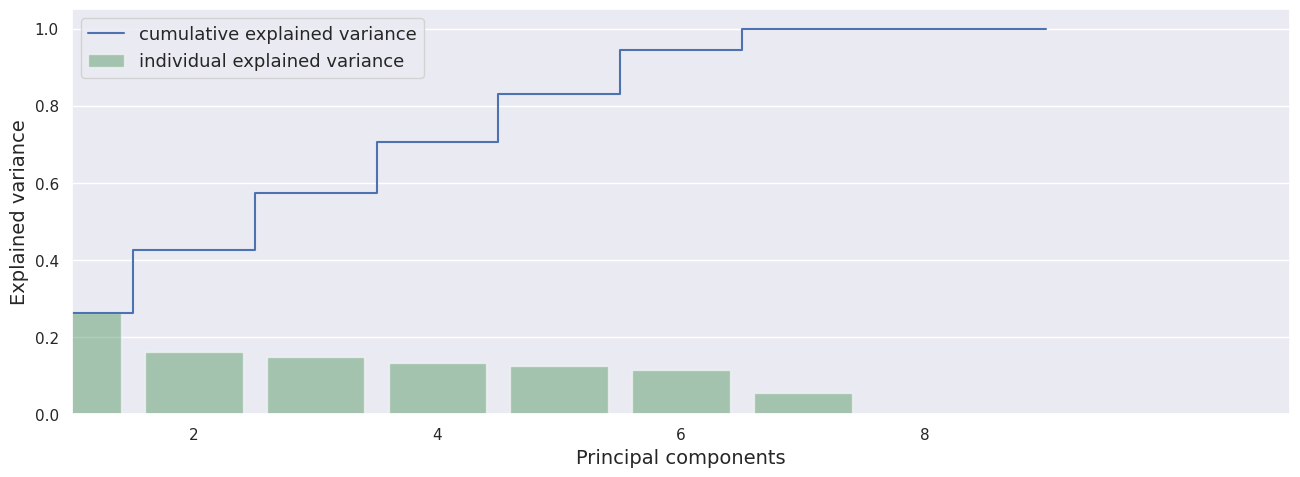

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the k-means algorithm fromscikit-learn. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 8 clusters:**

In [ ]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score of silhouette: {:<.3f}'.format(silhouette_avg))

score of silhouette: 0.238


In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no of clients']).T

,9,0,1,6,4,10,5,2,8,7,3
nb. de clients,79,44,39,26,26,21,16,9,4,1,1


In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

a / Report via the PCA

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

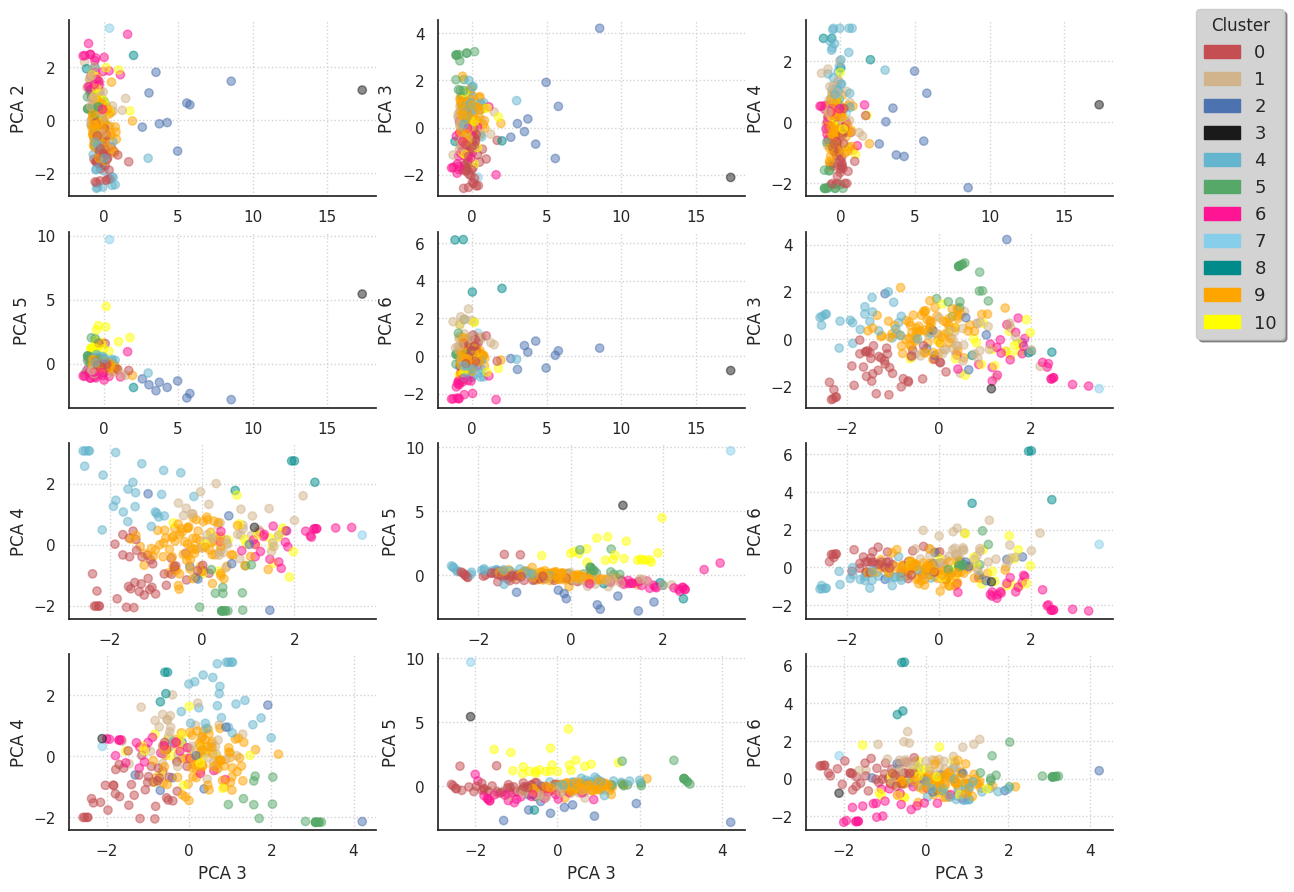

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

#------------------------------------------
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

b/ Score of silhouette intra-cluster

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

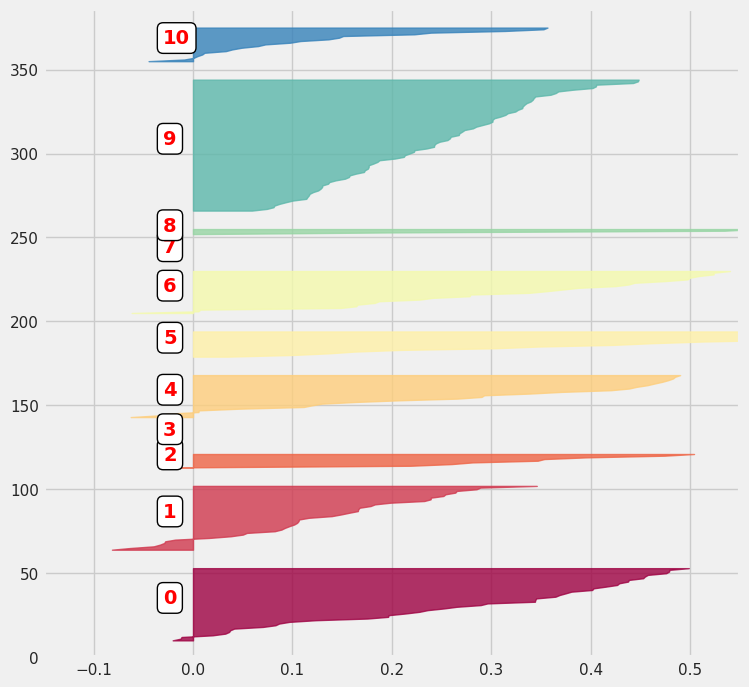

In [ ]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#----------------------------
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#-------------------------
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

c/ Customers morphotype

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:



In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#---------------------------------------
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 266


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [ ]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#------------------------------
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#------------------------------------
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,8.0,1.000000,556.890000,556.890000,556.890000,556.890000,81.799555,0.000000,3.627208,10.348606,4.224631,4
1,5.0,1.125000,183.280625,209.136875,196.208750,212.905625,4.128527,83.760925,1.276941,5.826445,5.007162,16
2,4.0,1.000000,335.699615,335.699615,335.699615,335.699615,4.191766,12.570866,68.061278,7.394761,7.781329,26
3,6.0,1.076923,280.746538,389.511923,335.129231,393.313846,3.115275,14.328907,4.380412,72.057923,6.117483,26
4,0.0,1.045455,290.354091,306.673409,298.513750,308.842727,3.312523,11.672552,11.709434,11.935731,61.369761,44
5,9.0,1.000000,321.352658,321.352658,321.352658,321.352658,5.645483,31.977132,23.109200,20.096390,19.171795,79
6,1.0,1.000000,326.262564,326.262564,326.262564,326.262564,23.966098,21.219124,13.749868,27.399475,13.665436,39
7,10.0,2.238095,88.677143,595.494762,335.688810,744.319524,11.238862,29.128327,16.023478,29.761563,13.847770,21
8,7.0,8.000000,42.500000,491.380000,176.462500,1411.700000,22.251895,20.531983,9.608274,24.819013,22.788836,1
9,2.0,1.000000,2226.842222,2226.842222,2226.842222,2226.842222,6.966958,27.615015,16.099711,23.843719,25.474596,9


d / Customers morphology

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts"?

In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [ ]:
'''fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y]
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n {}'.format(index[ind]), color = 'r')
    ind += 1 '''

"fig = plt.figure(figsize=(10,12))\n\nattributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']\nranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]\nindex  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]\n\nn_groups = n_clusters ; i_cols = 3\ni_rows = n_groups//i_cols\nsize_x, size_y = (1/i_cols), (1/i_rows)\n\nfor ind in range(n_clusters):\n    ix = ind%3 ; iy = i_rows - ind//3\n    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            \n    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] \n    #______________________________________________________\n    data = np.array(merged_df.loc[index[ind], attributes])    \n    radar = RadarChart(fig, location, sizes, attributes, ranges)\n    radar.plot(data, color = 'b', linewidth=2.0)\n    radar.fill(data, alpha = 0.2, color = 'b')\n    radar.title(title = 'cluster n {}'.format(index[ind]), color = 'r')\n    ind += 1 "

it can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages ( mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count ).

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

# 5. Classifying the Customers based on some parameters

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Train-test Split

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

# Scalar Vector Machine

In [ ]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X = X_train, Y = Y_train)

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 37.04 % 


# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #------------------------------
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #-----------------------------
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #----------------------------------
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


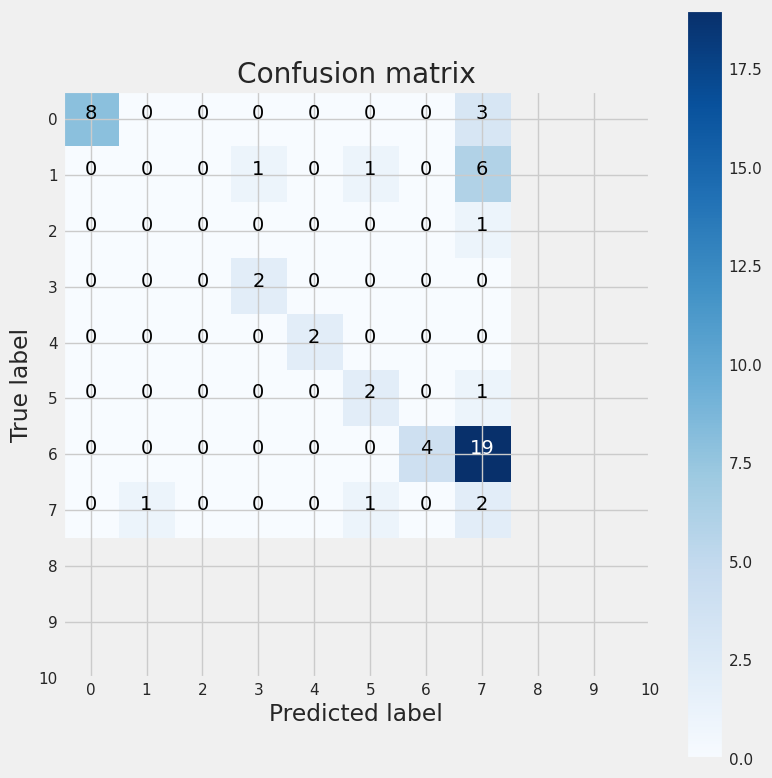

In [ ]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

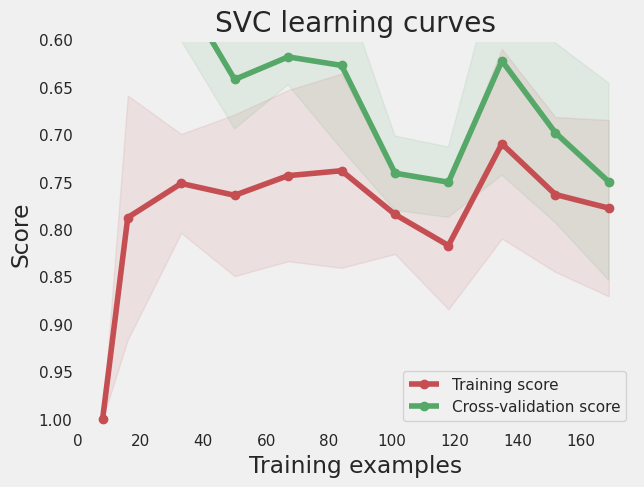

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 83.33 % 


# Logistic Regression

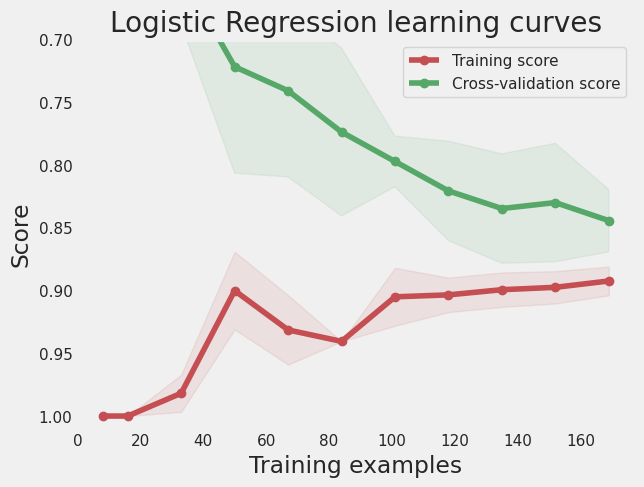

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# kNN

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 46.30 % 


# Decision tree Classifier

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 62.96 % 


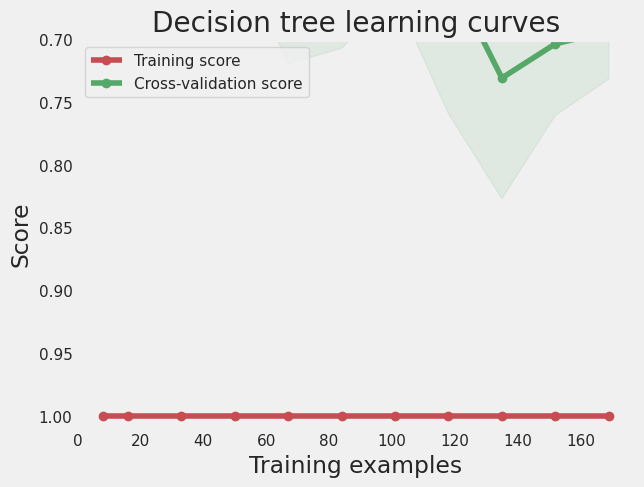

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#  Random Forest Classifier

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 83.33 % 


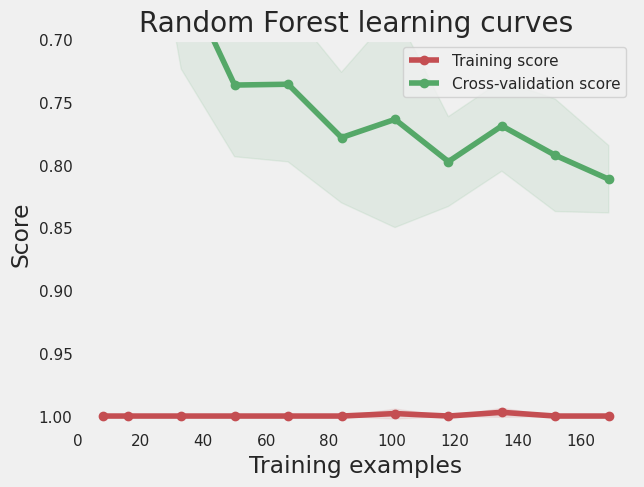

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Ada Boost Classifier

In [ ]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 64.81 % 


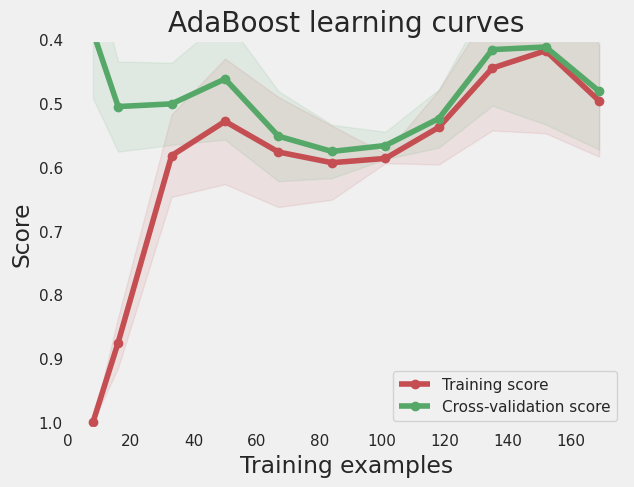

In [ ]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Gradient Boosting Classifier

In [ ]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 87.04 % 


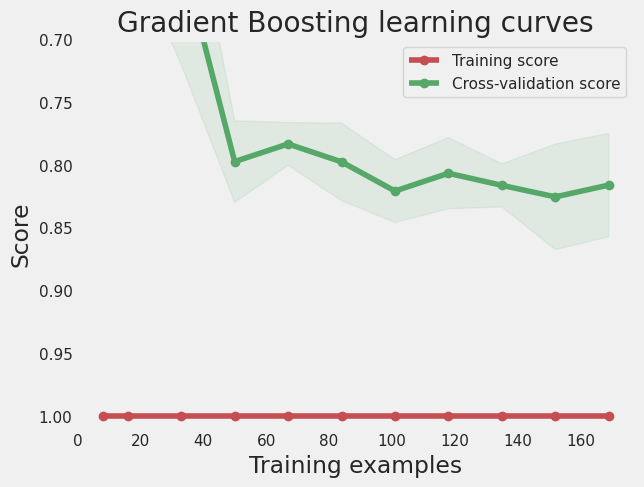

In [ ]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# 6. testing the Predictions

In [ ]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [ ]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [ ]:
votingC = votingC.fit(X_train, Y_train)

In [ ]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 88.89 % 
